In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Purpose of this Notebook

Investigate two methods of significance testing through the lens of marketing program optimization. The two methods are:

1. **Two-Tailed** test to see if treatment sample mean **is different** from control sample mean
2. **One-Tailed** test to see if there is a **positive difference** between treatment sample mean and control sample mean

The difference between those two methods seems like nuance. But it's theoretically huge.

In the first case, my implicit assumption is that the control group yielded its true mean during the experiment time frame. I establish a null hypothesis based around the control group's mean. Then, I contrast the treatment's mean with the control's mean to see if the treatment's mean is random, assuming the control mean is the true mean.

I also reject the null when a treatment underperforms the control. In reality, we wouldn't adopt a new idea if that happened. So, its external validity is low.

In the second case, my implicit assumption is that there is 0 difference between the control group's mean and the treatment group's mean. My null hypothesis is then based around a mean difference of 0. Then, I contrast the observed mean difference with the assumed difference of 0 and see if our observed difference occurred by chance or not.

I also reject the null only when the treatment outperforms the control. This more accurately reflects marketing decision making in the real world. A new idea is only getting adopted when it **beats** status quo.

## The implication is really about maximizing external validity

In both cases, the test is structured to measure what it purports to measure **within the sample**, so internal validty is high. 

In case one, I'm able to demonstrate that my treatment mean is likley different from my control mean. 

In case two, I'm able to demonstrate that my sample does or doesn't show a significant positive difference between the two means (treatment - control).

However, case 1 assumes that I didn't get the control mean by random chance. That it represents the population mean without the treatment. This reduces external validity. It forgets about biases involving the sample and time.

## And I want to answer this question

What would have to be the case for both to yield materially different results? (Results that change the decision being made)

# Part 0: Define Global Parameters
1. Control probability
2. Treatment probability
3. Group size (assume 50/50 split, so sample is 2x group_size)
4. Count of simulation runs

In [17]:
def sig_test_a(control_prob, treatment_prob, control_size = 1000, treatment_size = 1000, runs = 200000, plot = False):
    """
    Test for significance using the method in part 1, above. Default 2-tailed.
    
    Null: Treatment is not different than control.
    Alt: Treatment is different than control.
    
    Implicit assumption: Control's mean is the true population mean without treatment.
    """
    # This list will become our null distribution, later.
    sample_means = []
    
    for i in range(runs):
        # Simulate a bunch of datasets same size as control group
        # Add means of these simulations to sample_means to create null distribution of means
        # Null distribution based on control mean, because of our implicit assumption (see docstring)
        sample = np.random.choice([0,1], size = control_size, replace = True, p = [1-control_prob, control_prob])
        sample_means.append(np.mean(sample))
    
    # Sampling mean will serve as our contrast with the observed treatment mean when we calc p value
    sampling_mean = np.mean(sample_means)
    
    sample_means = np.asarray(sample_means)
    mean_diff = treatment_prob - sampling_mean
    
    # extreme_high and extreme_low let this script adapt to cases when treatment performs worse than control
    extreme_observed = treatment_prob
    extreme_inverse = sampling_mean - mean_diff
    extreme_high = max(extreme_observed, extreme_inverse)
    extreme_low = min(extreme_observed, extreme_inverse)
    
    print('Max extreme: {}'.format(extreme_high))
    print('Min extreme: {}'.format(extreme_low))
    
    # This is the part where we get p value. 
    # % of instances in null distribution that are equal to or more extreme than our observed treatement mean
    proportion_upper = (sample_means >= extreme_high).mean()
    proportion_lower = (sample_means <= extreme_low).mean()
    
    p = proportion_upper + proportion_lower
    print('P Value: {}'.format(p))
    
    if plot:
        fig, ax = plt.subplots(1,1,figsize=(8,6))
        
        ax.hist([w for w in sample_means if w < extreme_low], color = 'red', bins = 5)
        ax.hist([w for w in sample_means if w > extreme_high], color = 'red', bins = 5)
        ax.hist([w for w in sample_means if (w > extreme_low) and (w < extreme_high)], color = 'grey', bins = 10)
        ax.axvline(x = extreme_observed, linestyle = 'dashed', color = 'red')
        ax.axvline(x = extreme_inverse, linestyle = 'dashed', color = 'red')
        
        plt.show();
    
    return p

In [11]:
def sig_test_b(control_prob, treatment_prob, tails = 1, control_size = 1000, treatment_size = 1000, runs = 200000, plot = False):
    """
    Test for significance using the method in part 2, above. Default 1-tailed.
    
    Null: Difference treatment - control is 0 or less.
    Alt: Difference treatment - control is positive.
    
    Implicit assumption is that treatment and control are the same where the eval metric is concerned.
    The precise values obtained for each prob are less important.
    Greater external validity with this method in marketing program optimization contexts.
    """
    sample_prob = ((control_prob * control_size) + (treatment_prob * treatment_size)) / (control_size + treatment_size)
    print('Full Sample Probability: {:.4f}'.format(sample_prob))
    
    sample_means = []
    
    for i in range(runs):
        sample_control = np.random.choice(a = [0,1], size = control_size, p = [1-sample_prob, sample_prob])
        sample_treatment = np.random.choice(a = [0,1], size = treatment_size, p = [1-sample_prob, sample_prob])
        
        mean_difference = np.mean(sample_control) - np.mean(sample_treatment)
        
        sample_means.append(mean_difference)
        
    sample_means = np.asarray(sample_means)
    
    null_difference = np.mean(sample_means)
    observed_difference = treatment_prob - control_prob
    
    proportion_extreme = (sample_means >= observed_difference).mean()
    
    p = proportion_extreme
    print('P Value: {}'.format(p))
    
    if plot:
        fig, ax = plt.subplots(1,1,figsize = (8,6))
        
        ax.hist(x = [w for w in sample_means if w < observed_difference], color = 'grey', bins = 10)
        ax.hist(x = [w for w in sample_means if w >= observed_difference], color = 'red', bins = 5)
        ax.axvline(x = observed_difference, linestyle = 'dashed', color = 'red')
        
        plt.show();
    
    return p

In [5]:
# Define behavior rates
prob_control = 0.10
prob_treatment = 0.12
group_size = 1000
runs = 200000

# Part 1: Two-Tailed Test Contrasting Sample Means

Null Hypothesis: Treatment mean is not different than control mean. (Treatment conversion rate is same as control conversion rate)

Alt Hypothesis: Treatment mean is different than control mean. (Treatment conversion rate is different than control conversion rate)

In [2]:
## PSEUDO CODE

# Simulate distribution under null (treatment is not different than null) 
# Random draw 1 or 0 weighted for control conv rate 200,000 times

# Define extremeties using conversion rate of treatment (upper extreme, lower extreme)

# Measure % of null cases above and below those two extremes. That's p, baby.

Max extreme: 0.12
Min extreme: 0.07994688000000003
P Value: 0.03532


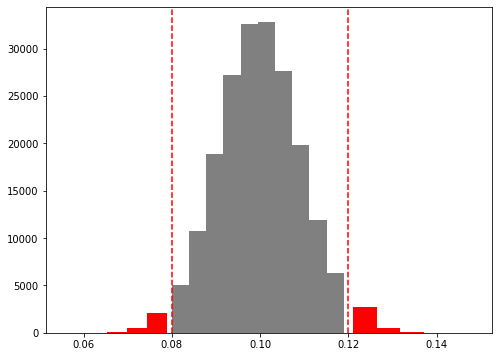

In [18]:
p_a = sig_test_a(prob_control, prob_treatment, plot = True)

# Part 2: One-Tailed Test Contrasting Presumed and Observed Differences

Difference = Treatment - Control

Null Hypothesis: The difference between the control conversion rate and treatment conversion rate is 0 or less.

Alt Hypothesis: The difference between the control conversion rate the treatment conversion rate is greater than 0.

Same procedure as above, with a few key differences:

1. Simulate treatment - control **differences** rather than control probabilities
2. One-tailed, so just need upper extremity and upper proportion for P value

Full Sample Probability: 0.1100
P Value: 0.082385


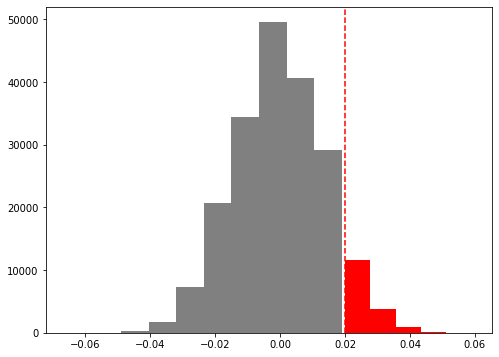

In [12]:
p_b = sig_test_b(prob_control, prob_treatment, plot = True)

# Part 3: When do the methods conclude differently?